In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import numpy as np
import scipy
import math
import pandas as pd
from PIL import Image
import cv2
import xml.etree.ElementTree as ET
%matplotlib inline

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import tensorflow.keras.utils
from sklearn.model_selection import train_test_split

In [2]:
absFolder=os.getcwd()
parentFolder = os.path.dirname(absFolder)
potholeFolder = os.path.join(parentFolder, 'NewData')
noPotholeFolder = os.path.join(parentFolder, 'NoPotholeData')
dataFolder = os.path.join(parentFolder, 'NewData')

In [3]:
labels = []


for bag in ['Bag1', 'Bag2', 'Bag3', 'Bag4', 'Bag5', 'RobotAvoid']:
    folderPath = os.path.join(dataFolder, bag)
    
    for filename in os.listdir(folderPath):
        if filename.endswith(".xml"):
            filepath = os.path.join(folderPath, filename)
            xml = ET.parse(filepath)
            annot = xml.getroot()
            fName = annot.find('filename').text
            size = annot.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            if width<40 or height<40 or width >999999 or height> 999999:
                continue
            
            imageFileName = os.path.join(folderPath, fName)
            
            objects = annot.findall('object')
            if len(objects)!=1:
                pass
            elif objects[0].find('name').text=='pothole':
                box = objects[0].find('bndbox')

                xmin = int(box.find("xmin").text)
                ymin = int(box.find("ymin").text)
                xmax = int(box.find("xmax").text)
                ymax = int(box.find("ymax").text)

                if xmin<0 or xmax>width or ymin<0 or ymax>height:
                    continue

                labels.append([fName, imageFileName, width, height, "pothole", xmin, ymin, xmax, ymax])

labelDf = pd.DataFrame(labels, 
                       columns=["filename", "imageFilePath", "width", 'height', "class", 'xmin', 'ymin', 'xmax', 'ymax'])

In [4]:
newSize = (128, 128)
def retrieveImage(fPath):
#     fPath = os.path.join(allImagesFolder, fName)
    pic = np.asarray(Image.open(fPath).convert('RGB').resize(newSize)) / 255.0
    return pic

In [5]:
# retrieve the images linked in the annotations
X = np.array(labelDf.imageFilePath.apply(retrieveImage).tolist())

In [6]:
Y = np.ones(X.shape[0])

In [7]:
Y.shape

(4248,)

In [8]:
noPotholesX = []
noPotholesY = []


for bag in ['Bag6', 'Bag7', 'Bag8', "RobotAvoid"]:
    folderpath = os.path.join(noPotholeFolder, bag)
    for filename in os.listdir(folderpath):
        if filename.endswith(".jpg"):
            fPath = os.path.join(folderpath, filename)
            pic = np.asarray(Image.open(fPath).convert('RGB').resize(newSize)) / 255.0
            noPotholesX.append(pic)
            noPotholesY.append(0)
noPotholesX = np.asarray(noPotholesX)
noPotholesY = np.asarray(noPotholesY)

print(noPotholesX.shape)
print(noPotholesY.shape)

(2755, 128, 128, 3)
(2755,)


In [9]:
X = np.concatenate((X, noPotholesX))
Y = np.concatenate((Y, noPotholesY))
print(X.shape)
print(Y.shape)

(7003, 128, 128, 3)
(7003,)


In [10]:
# X = []
# Y = []

# newSize = (128, 128)
# for dirname, folders, files in os.walk(potholeFolder):
#     if ".ipynb" not in dirname:
#         for file in files:
# #             print("{},   {}".format(dirname, file))
#             if file[-3]=='jpg':
#                 fPath = os.path.join(dirname, file)
                
#                 pic = np.asarray(Image.open(fPath).convert('RGB').resize(newSize)) / 255.0
#                 X.append(pic)
#                 Y.append(1)

# for dirname, folders, files in os.walk(noPotholeFolder):
#     if ".ipynb" not in dirname:
#         for file in files:
#             fPath = os.path.join(dirname, file)
#             pic = np.asarray(Image.open(fPath).convert('RGB').resize(newSize)) / 255.0
#             X.append(pic)
#             Y.append(0)

# X = np.asarray(X)
# Y = np.asarray(Y)
        

    

In [11]:
print(X.shape)
print(Y.shape)

(7003, 128, 128, 3)
(7003,)


In [12]:
# do a random split to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=41)

In [13]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5602, 128, 128, 3)
(5602,)
(1401, 128, 128, 3)
(1401,)


In [14]:
max_brightness_factor = 0.2
max_rotation_angle = 40
max_shift = 0.15

class PotholeBatchGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, 
                x_set,
                y_set,
                batch_size,
                image_dims=newSize,
                 shuffle=True,
                 num_channels=3,
                 num_outputs=1,
                 is_train=True):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dims = image_dims
        self.shuffle=shuffle
        self.num_channels = num_channels
        self.num_outputs = num_outputs
        self.num_images = self.x.shape[0]
        self.indexes = np.arange(self.num_images)
        self.is_train = is_train
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(self.num_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.num_images)
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dims, self.num_channels))
        y = np.empty((self.batch_size))
        
        for i in range(self.batch_size):
            y[i] = self.y[batch_indexes[i]]
            
            flip_flag = np.random.randint(2)
            if flip_flag ==1 and self.is_train:
                x[i, :, :, :] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
            else:
                x[i, :, :, :] = self.x[batch_indexes[i],:,:,:]
                
            
            
            
            if self.is_train:
                brightness_mult = np.random.random()*max_brightness_factor*2 - max_brightness_factor + 1
                x[i,:,:,:] = brightness_mult * x[i,:,:,:]
                
        if self.is_train:
            angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
            
            x = scipy.ndimage.interpolation.rotate(x, angle, (2,1), False, mode="constant", cval=0, order=0)
            
            shift = np.random.random()*2*max_shift - max_shift
#             shift=0.2
            M = np.float32([[1,0,shift*newSize[0]], [0,1,0]])
            
#             x = scipy.ndimage.interpolation.shift(x, (0, 0, shift*newSize[0],  0), mode="constant", cval=0)
            for i in range(self.batch_size):
                x[i] = cv2.warpAffine(x[i], M, newSize)
            
        else:
            angle = 0
            shift = 0
        
        
        
        return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


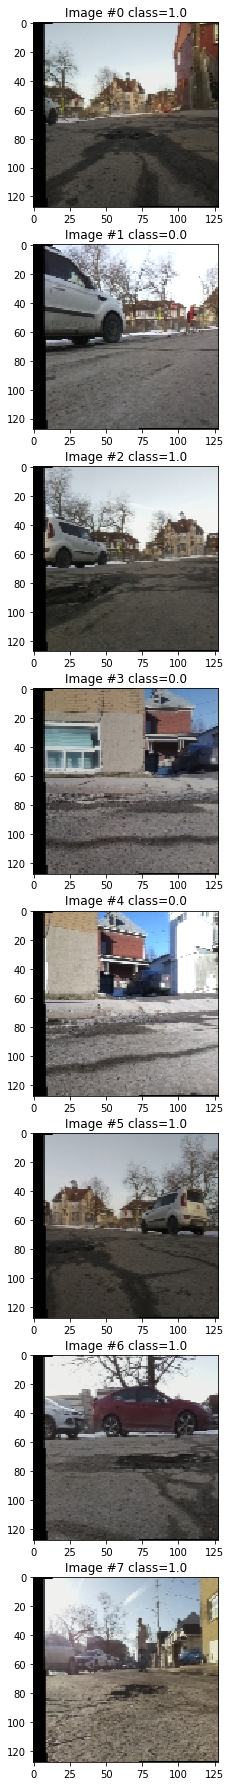

In [15]:
# looking at batch generator

batch_size = 8
num_show=8

gen = PotholeBatchGenerator(X, Y, batch_size, shuffle=True, is_train=True)

bx, by = gen.__getitem__(0)

fig = plt.figure(figsize=(18,4*num_show))
for i in range(num_show):
    a1 = fig.add_subplot(num_show, 3, i*3+1)
    img1 = a1.imshow(bx[i,:,:,:])
    a1.set_title("Image #{} class={}".format(i, by[i]))

In [29]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(newSize[0],newSize[1], 3), activation='relu'))
# model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.10))

# model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.15))

# model.add(Conv2D(64, (2,2), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.20))

# model.add(Conv2D(128, (2,2), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# model.add(Conv2D(256, (2,2), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Dense(128))

model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))


In [30]:
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
train_gen = PotholeBatchGenerator(X_train, Y_train, 8)
test_gen = PotholeBatchGenerator(X_test, Y_test, 8, is_train=False)

In [32]:
history = model.fit_generator(train_gen, validation_data=test_gen, epochs=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 700 steps, validate for 175 steps
Epoch 1/10
700/700 [==============================] - 24s 34ms/step - loss: 0.5008 - accuracy: 0.7468 - val_loss: 0.2974 - val_accuracy: 0.8821
Epoch 2/10
700/700 [==============================] - 23s 32ms/step - loss: 0.3152 - accuracy: 0.8675 - val_loss: 0.1958 - val_accuracy: 0.9329
Epoch 3/10
700/700 [==============================] - 23s 33ms/step - loss: 0.2409 - accuracy: 0.8989 - val_loss: 0.0877 - val_accuracy: 0.9714
Epoch 4/10
700/700 [==============================] - 23s 32ms/step - loss: 0.2164 - accuracy: 0.9121 - val_loss: 0.1281 - val_accuracy: 0.9514
Epoch 5/10
700/700 [==============================] - 23s 32ms/step - loss: 0.1666 - accuracy: 0.9359 - val_loss: 0.0767 - val_accuracy: 0.9729
Epoch 6/10
700/700 [==============================] - 22s 32ms/step - loss: 0.1602 - accuracy: 0.9371 - val_loss: 0.0684 - val_accuracy: 0.9721
Epoch 7/10
700/700 [======================

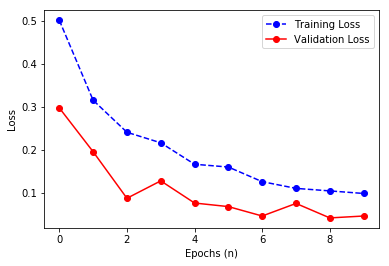

In [33]:
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'] ,'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

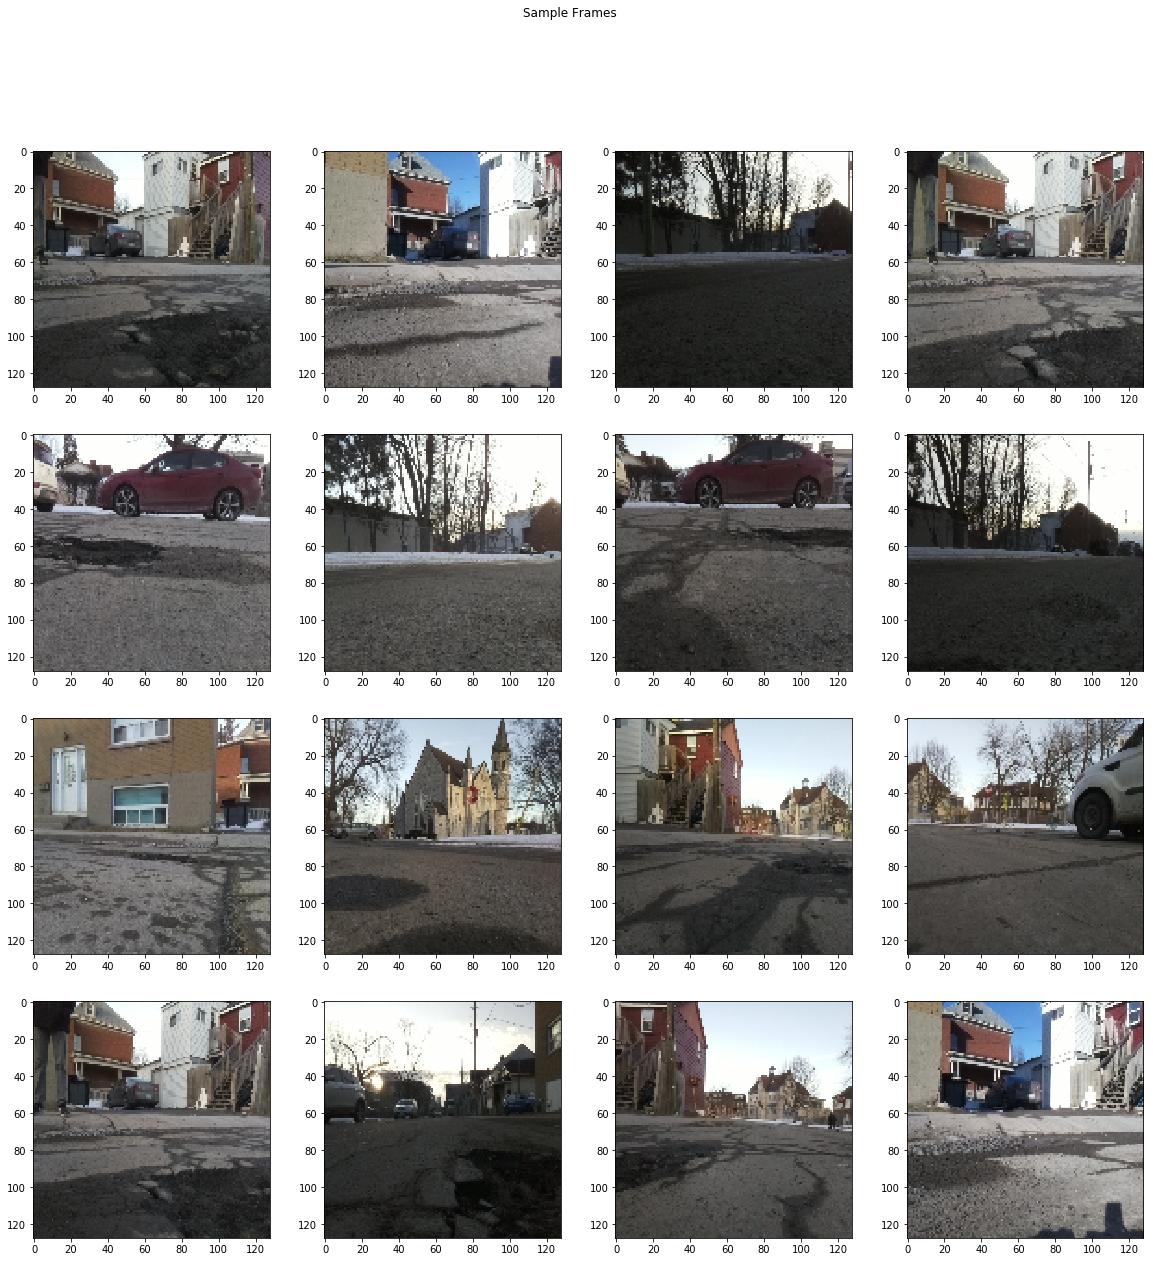

In [34]:
shift = 26
sampleNum = 16
fig, axs = plt.subplots(sampleNum//4, 4, figsize=(20,20))
fig.suptitle("Sample Frames")

for imgNum in range(sampleNum):
    plt.imshow(X_test[imgNum])
    axs[imgNum//4][imgNum%4].imshow(X_test[20+imgNum + shift])
    
    
    y_actuals = Y_test[20+imgNum + shift]
    y_preds = model.predict(np.expand_dims(X_test[20+imgNum + shift], axis=0))
    

    


In [36]:
w=10
h=10
fig=plt.figure(figsize=(128, 128), tight_layout=True)
cols=2
rows=2

num_choices = cols

sample_total = 0
sample_correct = 0

for row in range(1, rows + 1):
    x,y = test_gen.__getitem__(5*row)
    test_indices = range(batch_size)
    random_choice = np.random.choice(test_indices, num_choices)
    for col in range(1, cols + 1):
        img = x[random_choice[col-1]][:,:,:]
        #print(img.shape)
        #img = np.random.randint(10, size=(w,h))
        #prediction = model.predict(np.expand_dims(img, 0))
        prediction = model.predict(np.expand_dims(img, 0))[0][0]
        correct_label = y[random_choice[col-1]]
        print(int(round(prediction)))
        text = str(int(round(prediction))) + ": " + "\nActual: " + str(int(round(correct_label)))
        place = cols*(row-1) + col
        ax = fig.add_subplot(rows, cols, place, label=str(place))
        ax.set_title(text, size=180)
        plt.imshow(img)
        if str(prediction) == str(correct_label):
            sample_correct+=1
        sample_total+=1
        # print("row {}, col {}".format(row, col))
plt.show()

1
0
0
1


In [37]:
from datetime import datetime
timeStamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_file_path = os.path.join(absFolder, "classification_model_" + timeStamp +"notebookdemo"+ ".h5")
model.save(model_file_path)
print("Model saved to {}".format(model_file_path))

Model saved to /home/jupyter/Robo-Traverse/Notebooks/classification_model_2020-03-05_23-19-33notebookdemo.h5
